In [1]:
%matplotlib inline
import numpy as np
import warnings
import matplotlib.pyplot as plt
import scipy.signal as sig
import os
import Tools3D as tools3d
from numpy.fft import rfft, irfft 

warnings.filterwarnings("ignore")
#Vitesse du son au moment de la mesure, dependant de la temperature:
Tc = 21.5 
C = np.sqrt( 1.4 * 287 *(Tc + 273) )
Path = './'
DatFiles = [f for f in os.listdir('./marteau') if f.endswith('.dat')]
print(DatFiles)
NbMems = 256
NbVoies = 260
Fe = 50000
WinLen = 10000
iDly = 5
NbPings = 5
NbViol = 6

['hammer1.dat', 'hammer11.dat', 'hammer13.dat', 'hammer4.dat', 'hammer5.dat', 'hammer9.dat']


NameError: name 'Mics' is not defined

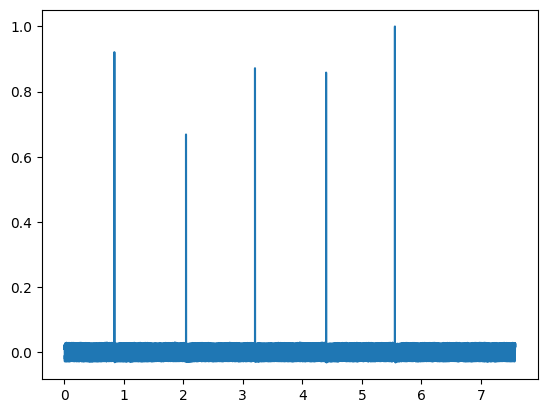

In [2]:
from scipy.signal import butter, filtfilt

# Design a Butterworth filter
cutoff = 5000  # Cutoff frequency in Hz
order = 5  # Filter order
b, a = butter(order, cutoff / (0.5 * Fe), btype='low')

FramesHmr = []
FramesMcr = []
FramesMms = []
    
for f in DatFiles:
    with open('./marteau/' + f) as DatFile : 
        data = np.fromfile(DatFile, dtype='int32').reshape((-1, NbVoies))
        compteur = data[:,0]
        Mems = data[:, 1:NbMems+1].astype('float')
        Refs = data[:, NbMems+1:].astype('float')
        NbEch = data.shape[0]
        t = np.arange(NbEch)/Fe
    Hammer = Refs[:,2]
    Micref = Refs[:,1]
    tW = np.arange(WinLen)/Fe
    plt.figure()
    for i in range(NbPings):
        Hammer /= np.max(np.abs(Hammer))
        plt.plot(t, Hammer)
        for j in range(len(Hammer)):
            if Hammer[j]>0.1:
                iTrig = j - iDly
                j += WinLen - iDly
                Hmr = Hammer[iTrig:iTrig+WinLen]
                Hmr -= np.mean(Hmr[100:500])
                Mcr = Micref[iTrig:iTrig+WinLen]
                Mms =  Mems[:, iTrig:iTrig+WinLen]
              
                FramesHmr.append(Refs[iTrig:iTrig+WinLen, 2])
                FramesMcr.append(Refs[iTrig:iTrig+WinLen, 1])
                FramesMms.append(Mics[iTrig:iTrig+WinLen, :])
                break                    

        Hammer = Hammer[j:]-np.mean(Hammer[j:])
        Micref = Micref[j:] 
        Mems = Mems[:,j:]

    
# FramesHmr = np.array(FramesHmr)
# FramesMcr =  np.array(FramesMcr)
# FramesMms = np.rollaxis(np.array(FramesMms), 2,1)            
        
# np.savez('./marteau/PingsAll.npz', t=t, Hmr=FramesHmr, Mcr = FramesMcr, Mms = FramesMms)

## Analyse de la RI comme RIR
Les indices standards extraits de l'analyse de la réponse impulsionnelle d'une salle incluent généralement les suivants :

1. **Temps de Réverbération (RT60)** : Le temps nécessaire pour que le niveau sonore diminue de 60 dB après l'arrêt de la source sonore.

2. **Early Decay Time (EDT)** : Le temps nécessaire pour que le niveau sonore diminue de 10 dB, extrapolé pour estimer le RT60.

3. **Clarity (C50, C80)** : Mesure de la clarté du son, définie comme le rapport entre l'énergie sonore précoce (dans les 50 ms ou 80 ms) et l'énergie sonore tardive.

4. **Définition (D50)** : Le pourcentage de l'énergie sonore totale qui arrive dans les 50 ms suivant l'arrivée du son direct.

5. **Centre Temporel (Ts)** : Le moment où l'énergie cumulative atteint 50 % de l'énergie totale.

6. **Rapport Signal/Bruit (SNR)** : Le rapport entre le niveau du signal utile et le niveau du bruit de fond.


### Analyse de l'enveloppe des signaux

In [7]:
# Recalage des signaux par cross-correlation
Ofst = 0
FramesMmsF = FramesMms.reshape(NbViol, NbPings*NbMems, WinLen)
FramesMmsF = filtfilt(b,a, FramesMmsF, axis = -1)
framesMmsF = FramesMmsF[:,:,Ofst:]
framesMmsF /= np.max(np.abs(framesMms), axis = -1)[:, :, None]
SpecMms = rfft(framesMms, axis = -1)
FramesMmsA = np.zeros_like(FramesMmsF)
plt.figure()
cmap = plt.get_cmap('jet')
for i in range(NbViol):
    for j in range(NbPings*NbMems):        
        XC = irfft(SpecMms[i,j,:] * np.conj(SpecMms[i,0,:]), axis = -1)
        shift = np.argmax(np.abs(XC))
        if shift > WinLen//2:
            shift += Ofst
        FramesMmsA[i,j,:] = np.roll(FramesMmsF[i,j,:], -shift)
        FramesMmsA[i,j,:] /= np.max(np.abs(FramesMmsA[i,j,:]))
    _ = plt.plot(2.5*i + FramesMmsA[i,:,:].T, color=cmap(50*i), lw=0.25)
plt.xlim(0, 1000)
plt.grid(True)
plt.show()


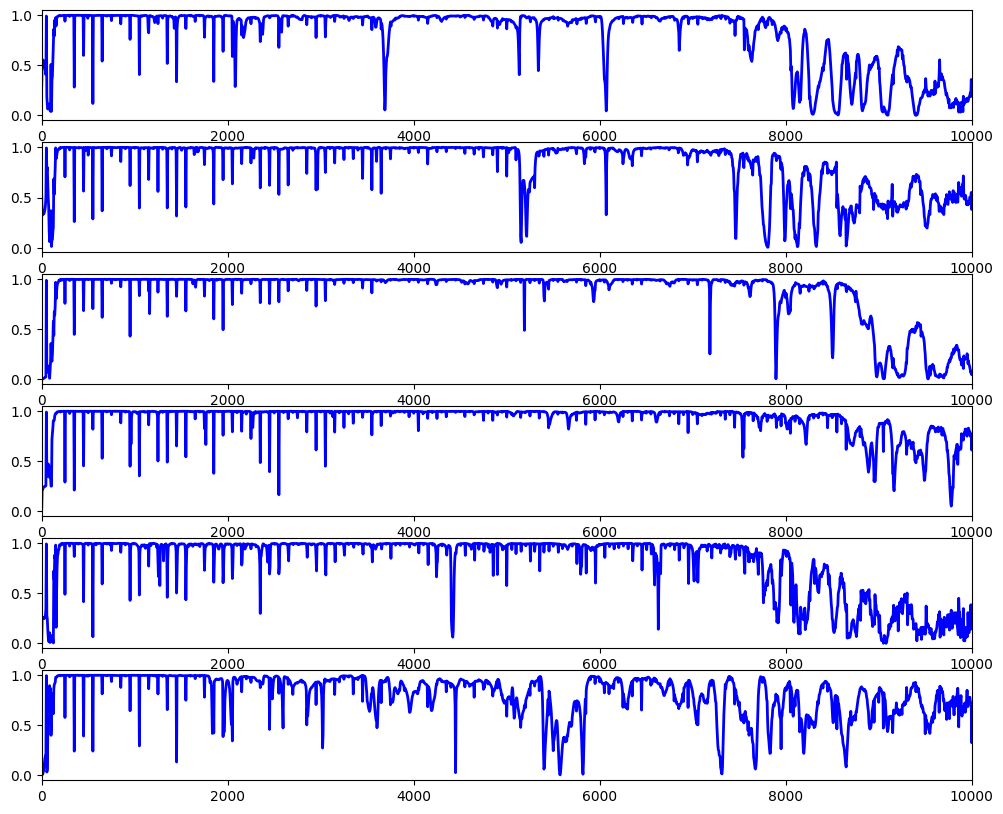

In [12]:
# Nfft = 10000
# NTrt = Nfft
# NOvlp = int(0.5*NTrt)
# plt.figure()
# col = ['y', 'r', 'b' ,'g', 'k', 'm', 'c']

# i = 0
# for f in DatFiles :
#     t =  np.load('./marteau/'+f[:-4]+'.npz')['t']
#     Mics = np.load('./marteau/'+f[:-4]+'.npz')['Mics']
#     Refs = np.load('./marteau/'+f[:-4]+'.npz')['Refs']
    
#     frq, Sm = sig.welch(Mics,               fs=Fe, axis = 0, nperseg = NTrt, nfft = Nfft, noverlap = NOvlp)
#     _,   Sr = sig.welch(Refs[:,2],          fs=Fe,           nperseg = NTrt, nfft = Nfft, noverlap = NOvlp)
#     _,  Srm = sig.csd(Refs[:,2][:,None], Mics,fs=Fe, axis = 0, nperseg = NTrt, nfft = Nfft, noverlap = NOvlp)
#     H = Srm/Sr[:,None]

#     _=plt.plot(frq,20*np.log10(np.abs(H[:,0])), c=col[i], lw = 0.2)
#     i+=1
    

# plt.xlim(100,5000)    
# plt.show()
    

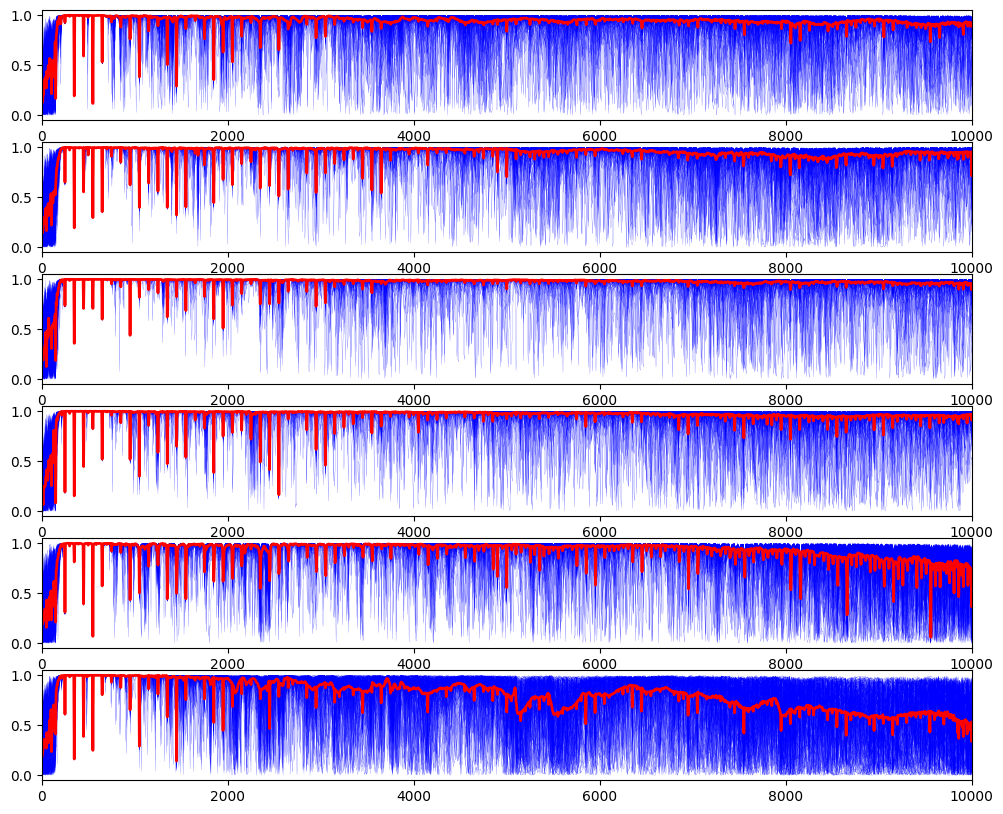

In [20]:
plt.plot(frq, 10*np.log10(np.abs(H[:,0])))
plt.xlim([100,5000])
plt.show()